```{figure} ../images/qpe-car.png
:width: 100%
:align: center
:name: qpe-car
Acumulado de precipitación en el radar de Guaviare

# Estimación Cuantitativa de la Lluvia 

---

## 🧭 Introducción

En este cuadernillo aprenderás cómo estimar la lluvia acumulada (QPE, Quantitative Precipitation Estimation) a partir de datos de reflectividad. Usaremos una relación empírica Z–R para convertir reflectividad en tasa de precipitación, y luego integraremos en el tiempo para obtener acumulados.

Los datos provienen del radar meteorológico ubicado en **Guaviare, Colombia**, y están preprocesados en formato Zarr siguiendo los principios FAIR.

## 📚 ¿Qué vas a aprender?

✔ Cómo aplicar relaciones Z–R para estimar lluvia a partir de reflectividad  
✔ Cómo calcular acumulados de precipitación sobre tiempo con datos radar  
✔ Cómo visualizar mapas de lluvia en 2D usando `xarray` y `matplotlib`  
✔ Cómo usar datos radar del radar Guaviare desde Zarr en la nube  

## ✅ Requisitos Previos

```{list-table}
:header-rows: 1
* - Concepto
  - Importancia
  - Enlace sugerido
* - Python y Xarray
  - Manipulación de datos multidimensionales
  - [Intro Xarray](../1.fundamentos/1.4.Introduccion-Xarray.ipynb)
* - Radar meteorológico
  - Interpretación física de la reflectividad (dBZ)
  - [Radar básico](../1.fundamentos/1.5.Introduccion-Radar.ipynb)

## 1. ☔ Fundamento: Estimación Cuantitativa de Precipitación (QPE)

La **estimación cuantitativa de precipitación (QPE)** consiste en transformar la reflectividad medida por el radar (en unidades dBZ) a una tasa de precipitación (mm/h), usando una relación empírica del tipo:

```{math}
Z = a \cdot R^b

Una de las más utilizadas es la relación de [Marshall y Palmer (1948)](https://doi.org/10.1175/1520-0469(1948)005%3C0165:TDORWS%3E2.0.CO;2):

```{math}
Z = 200 \cdot R^ {1.6}

:::{note}
Primero se debe transformar la reflectividad de dBZ a Z en unidades lineales, aplicar la fórmula para obtener 
𝑅, y finalmente multiplicar por el intervalo de tiempo para obtener la profundidad acumulada.
:::

In [1]:
from dask.distributed import Client, LocalCluster

# Create a local cluster with correct arguments
cluster = LocalCluster(
    n_workers=4,              # Number of worker processes
    memory_limit='2GB'        # Per worker memory limit
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33341/status,
Dashboard: http://127.0.0.1:33341/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37441,Workers: 0
Dashboard: http://127.0.0.1:33341/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43481,Total threads: 3
Dashboard: http://127.0.0.1:35837/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:39595,


## 2. 🗂️ Acceso a datos del radar de Guaviare

En esta sección accederemos a datos del radar meteorológico ubicado en **San José del Guaviare, Colombia**. Estos datos han sido preprocesados y almacenados en formato **Zarr v3**, siguiendo los principios FAIR (Findable, Accessible, Interoperable, Reusable), y se encuentran disponibles públicamente a través del servicio en la nube **Jetstream 2**.

Usaremos `xarray` y `fsspec`

In [2]:
import xarray as xr

# URL del endpoint S3 en Jetstream 2
url = "https://js2.jetstream-cloud.org:8001/"
path = "s3://pythia/radar/AtmosCol2025/Guaviare.zarr"

# Abrir el DataTree del radar
dtree = xr.open_datatree(
    path,
    # "/media/alfonso/drive/Alfonso/python/raw2zarr/zarr/Guaviare.zarr",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,
        "storage_options": {
            "anon": True,
            "client_kwargs": {
                "endpoint_url": url,
            },
        },
    },
)

In [3]:
display(dtree)

<xarray.DataTree>
Group: /
├── Group: /PRECA
│   │   Dimensions:        (vcp_time: 59)
│   │   Coordinates:
│   │     * vcp_time       (vcp_time) datetime64[ns] 472B 2025-06-19T18:17:09 ... 202...
│   │   Data variables:
│   │       altitude       (vcp_time) float32 236B dask.array<chunksize=(1,), meta=np.ndarray>
│   │       latitude       (vcp_time) float32 236B dask.array<chunksize=(1,), meta=np.ndarray>
│   │       longitude      (vcp_time) float32 236B dask.array<chunksize=(1,), meta=np.ndarray>
│   │       volume_number  (vcp_time) float64 472B dask.array<chunksize=(1,), meta=np.ndarray>
│   │   Attributes:
│   │       Conventions:      None
│   │       instrument_name:  guaviare
│   │       version:          None
│   │       title:            None
│   │       institution:      None
│   │       references:       None
│   │       source:           Sigmet
│   │       history:          None
│   │       comment:          Segunda tarea del modo procipitacion / 1.5 - 2.4 - 3.1 ...
│   │       scan_name:        PRECA       
│   ├── Group: /PRECA/georeferencing_correction
│   │       Dimensions:    ()
│   │       Coordinates:
│   │           altitude   float64 8B ...
│   │           longitude  float64 8B ...
│   │           latitude   float64 8B ...
│   ├── Group: /PRECA/radar_parameters
│   │       Dimensions:    ()
│   │       Coordinates:
│   │           altitude   float64 8B ...
│   │           latitude   float64 8B ...
│   │           longitude  float64 8B ...
│   ├── Group: /PRECA/sweep_3
│   │       Dimensions:            (vcp_time: 59, azimuth: 360, range: 747)
│   │       Coordinates:
│   │         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│   │           altitude           float64 8B ...
│   │           elevation          (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
│   │           crs_wkt            int64 8B ...
│   │           latitude           float64 8B ...
│   │           longitude          float64 8B ...
│   │         * range              (range) float32 3kB 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │           time               (azimuth) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
│   │           x                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
│   │           y                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
│   │           z                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
│   │       Data variables: (12/14)
│   │           DB_DBZE8           (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           DB_HCLASS          (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           DBZH               (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           KDP                (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           PHIDP              (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           DB_DBTE8           (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           ...                 ...
│   │           SQIH               (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           VRADH              (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           WRADH              (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           ZDR                (vcp_time, azimuth, range) float32 63MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
│   │           sweep_fixed_angle  (vcp_time) float32 236B dask.array<chunksize=(1,), meta=np

:::{note}
Este conjunto de datos está disponible en:

s3://pythia/radar/AtmosCol2025/Guaviare.zarr

y es accesible de forma remota a través de Jetstream 2, una infraestructura en la nube con soporte para el protocolo S3.
:::

### 2.1 🔍 Exploración de la estructura del volumen radar

El radar de **San José del Guaviare** contiene múltiples modos de escaneo organizados como grupos dentro del `DataTree`, tales como `PRECA`, `PRECB`, `PRECC` y `SURVP`. Cada uno corresponde a una configuración de volumen distinta en el modo de precipitación.

Dentro de cada grupo se encuentran:

- Variables globales (`latitude`, `longitude`, `altitude`, etc.)
- Subgrupos de barrido (`sweep_0`, `sweep_1`, `sweep_2`, ...)
- Parámetros del radar (`radar_parameters`)
- Correcciones de georreferenciación (`georeferencing_correction`)


In [4]:
list(dtree.children)

['PRECA', 'SURVP', 'PRECB', 'PRECC']

Y los nodos hijos dentro de un volumen específico, por ejemplo `PRECA`:

In [5]:
list(dtree["PRECA"].children)

['georeferencing_correction',
 'radar_parameters',
 'sweep_3',
 'sweep_0',
 'sweep_1',
 'sweep_2']

:::{hint}
Los nombres como sweep_0, sweep_1, etc., representan los diferentes ángulos de elevación utilizados en el escaneo volumétrico.

Puedes acceder directamente a una variable como la reflectividad horizontal (DBZH) en el barrido más bajo con:

In [6]:
dtree["/PRECA/sweep_0/DBZH"]

<xarray.DataArray 'DBZH' (vcp_time: 59, azimuth: 360, range: 747)> Size: 63MB
dask.array<open_dataset-DBZH, shape=(59, 360, 747), dtype=float32, chunksize=(1, 360, 747), chunktype=numpy.ndarray>
Coordinates:
  * vcp_time   (vcp_time) datetime64[ns] 472B 2025-06-19T18:17:09 ... 2025-06...
    altitude   float64 8B ...
  * azimuth    (azimuth) float32 1kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    crs_wkt    int64 8B ...
    elevation  (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    latitude   float64 8B ...
  * range      (range) float32 3kB 1e+03 1.3e+03 1.6e+03 ... 2.245e+05 2.248e+05
    longitude  float64 8B ...
    time       (azimuth) datetime64[ns] 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    x          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
    y          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
    z          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
Attributes:
    long_name:      Equivalent reflectivity factor H
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h

## 3. 🌧️ Cálculo de la Precipitación Acumulada

En esta sección estimaremos la profundidad de precipitación acumulada usando la reflectividad radar de Guaviare y una relación empírica tipo \( Z = a \cdot R^b \). Para ello, aplicaremos la fórmula de Marshall y Palmer y realizaremos una integración temporal sobre cada píxel.

La función `rain_depth()` implementa este proceso completo de forma vectorizada usando `xarray`.

### 3.1 Definición de la función `rain_depth`

In [7]:
def rain_depth(
    z: xr.DataArray, a: float = 200.0, b: float = 1.6, t: int = 5
) -> xr.DataArray:
    """
    Estima la profundidad de precipitación acumulada a partir de la reflectividad radar.

    Parámetros
    ----------
    z : xr.DataArray
        Reflectividad en dBZ o Z lineal (se determina automáticamente por las unidades).
    a : float, opcional
        Parámetro 'a' en la relación Z-R. Valor por defecto: 200.0.
    b : float, opcional
        Parámetro 'b' en la relación Z-R. Valor por defecto: 1.6.
    t : int, opcional
        Intervalo de tiempo en minutos entre volúmenes. Default: 5.

    Retorna
    -------
    xr.DataArray
        Profundidad de lluvia estimada (en mm) por píxel.
    """
    # Revisión de unidades
    units = z.attrs.get("units", "")

    # Convertimos dBZ a Z lineal si es necesario
    if units.startswith("dB"):
        z_lin = 10 ** (z / 10)
    else:
        z_lin = z  # ya está en unidades lineales

    # Aplicamos la relación Z-R e integramos en el tiempo
    r = ((1 / a) ** (1 / b)) * z_lin ** (1 / b)
    return r * (t / 60)  # profundidad acumulada en mm

:::{note}
Esta función:

- Convierte reflectividad de `dBZ` a \( Z \) en unidades lineales.
- Estima la tasa de precipitación \( R \) usando la relación:

  ```{math}
  Z = a \cdot R^b
- Multiplica por el intervalo temporal para obtener la profundidad acumulada en milímetros.
:::

### 3.2 Aplicación sobre datos del radar Guaviare (`SURVP/sweep_0`)

Usamos el barrido más bajo (`sweep_0`) del volumen `SURVP`, que corresponde a una elevación cercana a \(0.5^\circ\), ideal para estimar precipitación acumulada sobre la superficie.

Seleccionamos la reflectividad horizontal (`DBZH`) y aplicamos la función `rain_depth`.


In [8]:
# Selección del barrido y variable de reflectividad
ref_log = dtree["/SURVP/sweep_0/DBZH"]

In [9]:
# Cálculo de la precipitación acumulada (en mm) para cada volumen
rr = rain_depth(ref_log)

In [10]:
rr

<xarray.DataArray 'DBZH' (vcp_time: 122, azimuth: 720, range: 994)> Size: 349MB
dask.array<mul, shape=(122, 720, 994), dtype=float32, chunksize=(1, 720, 994), chunktype=numpy.ndarray>
Coordinates:
  * vcp_time   (vcp_time) datetime64[ns] 976B 2025-06-19T18:19:54 ... 2025-06...
  * azimuth    (azimuth) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    elevation  (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    longitude  float64 8B ...
    crs_wkt    int64 8B ...
    latitude   float64 8B ...
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    altitude   float64 8B ...
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    x          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    y          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>

## 3.1 🧮 Estimación de la lluvia total acumulada

Una vez calculada la tasa de precipitación para cada volumen, podemos estimar la **lluvia total acumulada** del evento sumando a lo largo del tiempo (`vcp_time`).


In [11]:
rr_total = rr.sum(dim="vcp_time", skipna=True)

In [12]:
rr_total

<xarray.DataArray 'DBZH' (azimuth: 720, range: 994)> Size: 3MB
dask.array<sum-aggregate, shape=(720, 994), dtype=float32, chunksize=(720, 994), chunktype=numpy.ndarray>
Coordinates:
  * azimuth    (azimuth) float32 3kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    elevation  (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    longitude  float64 8B ...
    crs_wkt    int64 8B ...
    latitude   float64 8B ...
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    altitude   float64 8B ...
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    x          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    z          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>
    y          (azimuth, range) float64 6MB dask.array<chunksize=(180, 249), meta=np.ndarray>

Visualizamos el campo acumulado:

CPU times: user 2.22 s, sys: 193 ms, total: 2.41 s
Wall time: 14.1 s


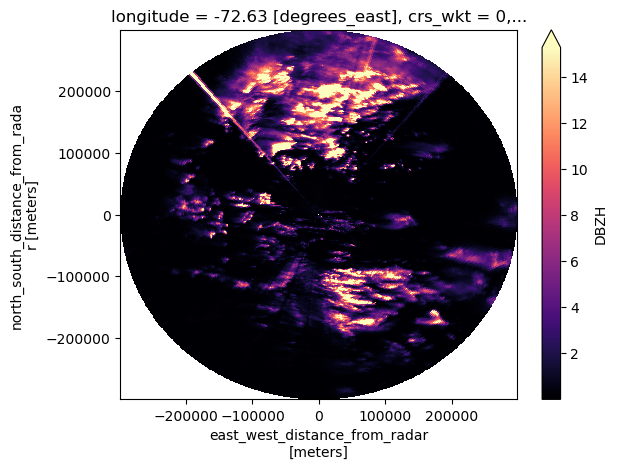

In [13]:
%%time
rr_total.plot(x="x", y="y", cmap="magma", robust=True);

:::{note}
Este campo representa la estimación total de precipitación (en mm) acumulada durante el periodo observado, basado en la relación Z-R de Marshall y Palmer.
:::

## 3.2 🧮 Acumulaciones parciales por intervalo de tiempo

El volumen radar cubre el periodo:

- **Inicio**: 2025-06-19 18:19 UTC  
- **Fin**: 2025-06-19 23:50 UTC

A continuación, estimaremos la lluvia acumulada para distintos intervalos:

1. Primera hora del evento
2. Primeras dos horas
3. Evento completo

In [14]:
# Conversión explícita a datetime64 para selección
import numpy as np
import matplotlib.pyplot as plt

t0 = np.datetime64("2025-06-19T18:19:00")
t1 = np.datetime64("2025-06-19T19:19:00")
t2 = np.datetime64("2025-06-19T20:19:00")

In [15]:
# Subconjuntos únicos para cada intervalo
rr_sel_1h = rr.sel(vcp_time=slice(t0, t1))
rr_sel_2h = rr.sel(vcp_time=slice(t1, t2))
rr_sel_remain = rr.sel(vcp_time=slice(t2, None))

In [16]:
# Acumulaciones parciales
rr_1h = rr_sel_1h.sum("vcp_time")
rr_2h = rr_1h + rr_sel_2h.sum("vcp_time")
rr_total =  rr_2h + rr_sel_remain.sum("vcp_time")

## 3.3 📊 Visualización de acumulaciones en distintos intervalos

A continuación, mostramos la estimación de lluvia acumulada para:

- Primer hora
- Primeras dos horas
- Evento completo

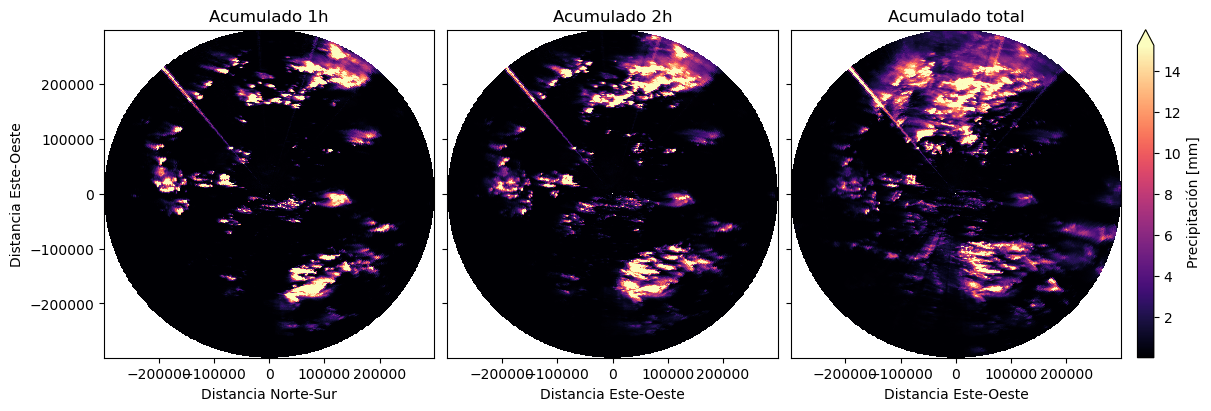

CPU times: user 8.99 s, sys: 572 ms, total: 9.56 s
Wall time: 37 s


In [18]:
%%time
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True, sharey=True)

# Primer hora
rr_1h.plot(
    ax=axs[0],
    cmap="magma",
    robust=True,
    x="x",
    y="y",
    add_colorbar=False, 
)

axs[0].set_title("Acumulado 1h")
axs[0].set_xlabel("Distancia Norte-Sur")
axs[0].set_ylabel("Distancia Este-Oeste")
# Dos horas
rr_2h.plot(
    ax=axs[1],
    cmap="magma",
    robust=True,
    x="x",
    y="y",
   add_colorbar=False, 
)

axs[1].set_title("Acumulado 2h")
axs[1].set_ylabel("")
axs[1].set_xlabel("Distancia Este-Oeste")
# Evento completo
rr_total.plot(
    ax=axs[2],
    cmap="magma",
    robust=True,
    x="x",
    y="y",
    cbar_kwargs={"label": "Precipitación [mm]"},
)
axs[2].set_title("Acumulado total")
axs[2].set_ylabel("")
axs[2].set_xlabel("Distancia Este-Oeste")

plt.savefig("../images/qpe-car.png", dpi=150, bbox_inches='tight')
plt.show()

:::{note}
La comparación permite identificar zonas con acumulaciones más persistentes y evaluar la evolución espacial del evento.
:::

## 5. ✅ Conclusiones

En este cuaderno exploramos el uso del radar meteorológico de **Guaviare (Colombia)** para realizar una **estimación cuantitativa de precipitación (QPE)** basada en reflectividad.

- Utilizamos datos en formato **Zarr** almacenados en la nube (Jetstream 2) para acceder y procesar reflectividades sin necesidad de descarga local.
- Aplicamos la relación empírica de **Marshall y Palmer (1948)** para convertir reflectividad (\( Z \)) en tasa de precipitación (\( R \)).
- Integrando la tasa en el tiempo, obtuvimos estimaciones de **profundidad de lluvia acumulada**.
- Visualizamos:
  - Precipitación acumulada para 1 volumen
  - Precipitación acumulada en 2 volúmenes consecutivos
  - Precipitación total para el evento completo

